# Multinomial Naive Bayes

In [66]:
#import statements
import pandas as pd
import numpy as np
from sklearn.naive_bayes import GaussianNB,MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from nltk.corpus import stopwords 
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn import metrics
from sklearn.metrics import roc_auc_score
from pandas_ml import ConfusionMatrix
import matplotlib as mp
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import os
import re


In [67]:
df = pd.read_csv(os.getcwd()+'/data/train_lyrics_1000.csv')
df.head()

,file,artist,title,lyrics,genre,mood,year
0,TRAAAAW128F429D538.h5,Casual,I Didn't Mean To,Verse One:\n\nAlright I might\nHave had a litt...,Hip Hop/Rap,sad,1994
1,TRAAAEF128F4273421.h5,Adam Ant,Something Girls,Adam Ant/Marco Pirroni\nEvery girl is a someth...,Rock,happy,1982
2,TRAAAFD128F92F423A.h5,Gob,Face the Ashes,"I've just erased it's been a while, I've got a...",Rock,sad,2007
3,TRAABJV128F1460C49.h5,Lionel Richie,Tonight Will Be Alright,Little darling \nWhere you've been so long \nI...,R&B,happy,1986
4,TRAABLR128F423B7E3.h5,Blue Rodeo,Floating,"Lead Vocal by Greg\n\nWell, these late night c...",Rock,sad,1987


In [68]:
df_test = pd.read_csv(os.getcwd()+'/data/valid_lyrics_200.csv')
df_test.head()

,file,artist,title,genre,lyrics,mood
0,TRAFAIB128F426E636.h5,Placebo,Where Is My Mind (XFM Live Version),Pop,Ooooohh\nOoooohh\nOoooohh\nOoooohh\n\nWith you...,happy
1,TRAFAJC128E078888B.h5,Queens Of The Stone Age,This Lullaby,Rock,"Where, oh, where have you been, my love?\nWher...",sad
2,TRAFBBP128F92F6CC9.h5,MC5,Looking At You (Cody High School),Rock,When it happened \nsomething snapped inside \n...,happy
3,TRAFBVU128F426B3F6.h5,Dimmu Borgir,The Fundamental Alienation,Rock,My eyes got blinded\nAnd conned by the light\n...,sad
4,TRAFEEO12903CFEC87.h5,Dark Fortress,The Silver Gate,Rock,"[Music: V Santura, Lyrics: Morean]\n\nAwake, a...",sad


#### Label Encoding

In [69]:
#train dataset label encoding
mood = df['mood']

le = LabelEncoder()
le.fit(mood)
mood = le.transform(mood)

X_train = df['lyrics']
Y_train = mood

#Test dataset label encoding
X_test = df_test['lyrics']
Y_test = df_test['mood']
le.fit(Y_test)
Y_test = le.transform(Y_test)


#### Stemming, removing stopwords and n-grams
#### Selecting the top 20k features only

In [70]:
porter_stemmer = nltk.stem.porter.PorterStemmer()

#spilts the sentences into words
def porter_tokenizer(text, stemmer=porter_stemmer):
    lower_txt = text.lower()
    tokens = nltk.wordpunct_tokenize(lower_txt)
    stems = [porter_stemmer.stem(t) for t in tokens]
    no_punct = [s for s in stems if re.match('^[a-zA-Z]+$', s) is not None]
    return no_punct

stop_words = set(stopwords.words('english')) 

#tfidf vectorizer
vectorizer = TfidfVectorizer(stop_words='english',
                                   encoding='utf-8',
                                   lowercase = True,
                                   decode_error='replace',
                                   strip_accents='unicode',
                                   analyzer='word',
                                   tokenizer=porter_tokenizer,
                                   ngram_range=(1,2),
                                   min_df = 2,
                                   binary=False)

#vectorized data
x_train = vectorizer.fit_transform(X_train)

x_test = vectorizer.transform(X_test)

# Feature selection
# Select top 'k' of the vectorized features.
selector = SelectKBest(f_classif, k=min(25000, x_train.shape[1]))
selector.fit(x_train, Y_train)

x_train = selector.transform(x_train).astype('float32')

x_test = selector.transform(x_test).astype('float32')

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'formerli', 'forti', 'ha', 'henc', 'hereaft', 'herebi', 'hi', 'howev', 'hundr', 'inde', 'latterli', 'mani', 'meanwhil', 'moreov', 'mostli', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'seriou', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'thi', 'thu', 'togeth', 'twelv', 'twenti', 'veri', 'wa', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev', 'whi', 'yourselv'] not in stop_words.
  'stop

#### Implementing the model (Since we are using vectorize data we will use Multinomial Naive Bayes)

In [71]:
#model implementation
mnb = MultinomialNB()
mnb.fit(x_train, Y_train)

pred = mnb.predict(x_test)

#### Model predictions (Actual vs Prediction)

In [72]:
#Actual vs prediction

#Take the two values for comparison as actual and predicted
pred_df = pd.DataFrame({'Actual': Y_test, 'Predicted': pred})

# pred_df.head(50)

#print the values
pred_df.head(20)

,Actual,Predicted
0,0,1
1,1,1
2,0,0
3,1,1
4,1,1
5,0,1
6,0,1
7,1,1
8,0,1
9,0,1


In [73]:
#Model Evaluation

def evaluation(cm):
    TP = cm[0][0]
    FP = cm[0][1]
    FN = cm[1][0]
    TN = cm[1][1]

    #Calculating precision
    def Precision_Cal(TP,FP):
        return TP/(TP+FP)

    #Calculating recall
    def Recall_Cal(TP,FN):
        return TP/(TP+FN)

    #Calculating F1 score
    def F1_Cal(precision,recall):
        f1 = 2*((precision * recall)/(precision+recall))
        print('F1 Score = ', f1)
        #print('F1 % = ', f1*100)

    #Calculating Error Rate
    def Err_Cal(TP,FP,FN,TN):
        return ((FP+FN)/(TP+FP+FN+TN))

    precision = Precision_Cal(TP,FP)
    print('Precision = ', precision)

    recall = Recall_Cal(TP,FN)
    print('Recall = ', recall)

    F1_Cal(precision,recall)

    Err_Rate = Err_Cal(TP,FP,FN,TN)
    print('Error Rate = ', Err_Rate)

    #Accuracy is 1-error rate
    print('Accuracy = ', 1-Err_Rate)
    
def rocCurve(y_true, y_pred, roc):
    fpr, tpr, thresholds = metrics.roc_curve(y_true, y_pred)
    # Plot ROC curve
    plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc)
    plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate or (1 - Specifity)')
    plt.ylabel('True Positive Rate or (Sensitivity)')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    
def plotConfusionMatrix(cm):
    np.set_printoptions(suppress=True)
    mp.rc("figure", figsize=(4, 2))

    hm = sns.heatmap(cm, 
                cbar=False,
                annot=True, 
                square=True,
                fmt='d',
                yticklabels=['happy','sad'],
                xticklabels=['happy','sad'],
                cmap='Blues'
                )
    plt.title('Confusion matrix - Validation dataset')
    plt.ylabel('actual class')
    plt.xlabel('predicted class')
    plt.tight_layout()
    plt.savefig('confmat_valid.eps', dpi=300)
    plt.show()

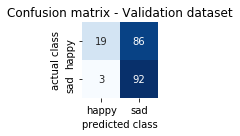

Precision =  0.18095238095238095
Recall =  0.8636363636363636
F1 Score =  0.2992125984251969
Error Rate =  0.445
Accuracy =  0.5549999999999999
ROC-AUC 0.5746867167919799


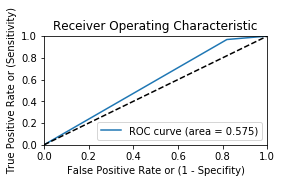

In [74]:
roc_auc = roc_auc_score(Y_test, pred, average= 'micro')

#confusion matrix for count vector
cm = metrics.confusion_matrix(Y_test, pred, labels=[0,1])

#plot the confusion Matrix
plotConfusionMatrix(cm)

rocCurve(Y_test, pred, roc_auc)

#Evaluation
evaluation(cm)
print("ROC-AUC", roc_auc)
